## Imports

In [2]:
# Preprocess Imports
import os
import numpy as np
from PIL import Image
%matplotlib inline
import matplotlib.pyplot as plt
from tqdm import tqdm
import cv2
import warnings
from model1pt.src.visualize import *

# Model Imports
from keras.preprocessing.image import img_to_array, load_img
from skimage.color import rgb2lab, lab2rgb, rgb2gray, gray2rgb
import tensorflow as tf
from tensorflow.keras.models import model_from_json
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2, preprocess_input
from skimage.transform import resize
from sklearn.metrics import accuracy_score

## Initialisation

In [3]:
############## PREPROCESSING DEFINITIONS ##############

# Path to the original data folder
PATH_TO_DATA_FOLDER = r"D:\College\Capstone\data_clean"

# Path to the initially empty folder to store the resized images
PATH_TO_RESIZED_FOLDER = r"D:\College\Capstone\data_clean\test\google_images\colored"

# Path to the initially empty folder to store the final greyscale images
# For Model1, put all the images you wish to color in this folder
PATH_TO_GRAYSCALE_FOLDER = r"D:\College\Capstone\data_clean\test\google_images\grayscale"

FLICKR_TRAINING_COLORED_FOLDER = r"D:\College\Capstone\data_clean\train\flickr\colored"
FLICKR_TRAINING_GRAYSCALE_FOLDER = r"D:\College\Capstone\data_clean\train\flickr\grayscale"
FLICKR_TESTING_FOLDER = r"D:\College\Capstone\data_clean\test\flickr"
FLICKR_TYPES = ["type_1", "type_2", "type_3", "type_4", "type_5", "type_6", "type_7"]

# Path to output folders
PATH_TO_MODEL1_OUTPUT = r".\model1pt\result_images"
PATH_TO_MODEL2_OUTPUT = r".\model2pt\result_images"

STANDARD_WIDTH = 256    # 420, 352
STANDARD_HEIGHT = 256    # 285, 240

SHOW_PROGRESS_COUNT = 10    # Shows progress after this many number of images are processed



############## MODEL DEFINITIONS ##############

PATH_TO_MODEL_1_JSON = r".\model1pt\model1-2.json"
PATH_TO_MODEL_1_WEIGHTS = r".\model1pt\model1-2.h5"

PATH_TO_MODEL_2_JSON = r".\model2pt\model2.json"
PATH_TO_MODEL_2_WEIGHTS = r".\model2pt\model2.h5"

## Distribution of widths and heights in a folder

In [11]:
def plot_distribution(x, title_text):
    values, bins, patches = plt.hist(x, bins = 5)
    values = [int(x) for x in values]
    bins = [int(x) for x in bins]
    max_frequency = max(values)
    max_frequency_indices = [i for i, e in enumerate(values) if e == max_frequency]
    max_bin_ends = [(bins[x], bins[x + 1]) for x in max_frequency_indices]
    max_bin_ends = [str(x) for x in max_bin_ends]
    plt.title("Distribution of " + title_text + ", Max bin: " + ", ".join(max_bin_ends))
    plt.show()

In [12]:
def plot_all_distributions(PATH_TO_DATA_FOLDER):
    all_widths = []
    all_heights = []

    for file_name in os.listdir(PATH_TO_DATA_FOLDER):
        image = Image.open(PATH_TO_DATA_FOLDER + "\\" + file_name)
        width, height = image.size
        if(height < 500 and width < 500):
#         if(True):
            all_widths.append(width)
            all_heights.append(height)

    plot_distribution(all_widths, "Widths")
    plot_distribution(all_heights, "Heights")

In [ ]:
plot_all_distributions(PATH_TO_DATA_FOLDER)

## Flickr Dataset

In [ ]:
def isbright(image, dim=10, thresh=0.5):
    imageCopy = image.copy()
    cv2Image = np.array(imageCopy)
    # Resize image to 10x10
    cv2Image = cv2.resize(cv2Image, (dim, dim))
    # Convert color space to LAB format and extract L channel
    L, A, B = cv2.split(cv2.cvtColor(cv2Image, cv2.COLOR_BGR2LAB))
    # Normalize L channel by dividing all pixel values with maximum pixel value
    L = L/np.max(L)
    # Return True if mean is greater than thresh else False
    return np.mean(L) > thresh

def getTypeName(fileName, types):
    if("(" not in fileName):
        return types[0]
    else:
        leftBracketIndex = fileName.find("(")
        if(leftBracketIndex != -1 and leftBracketIndex + 1 < len(fileName) and fileName[leftBracketIndex + 1].isnumeric() and int(fileName[leftBracketIndex + 1]) < 8):
            return types[int(fileName[leftBracketIndex + 1]) - 1]
        else:
            raise ValueError(f"Wrong file name: {fileName}")

def filter_all_images(PATH_TO_DATA_FOLDER, FLICKR_TESTING_FOLDER, FLICKR_TYPES, thresh = 0.5):
    typeCount = {typeName : 0 for typeName in FLICKR_TYPES}
    count = 0
    for file_name in tqdm(os.listdir(PATH_TO_DATA_FOLDER)):
        image = Image.open(PATH_TO_DATA_FOLDER + "\\" + file_name).resize((STANDARD_WIDTH, STANDARD_HEIGHT)).convert("RGB")
        if(isbright(image, thresh = thresh)):
            count += 1
            typeCount[getTypeName(file_name, FLICKR_TYPES)] += 1
            image.save(os.path.join(FLICKR_TESTING_FOLDER, getTypeName(file_name, FLICKR_TYPES), "colored", str(count) + ".jpg"))
            image.convert("L").save(os.path.join(FLICKR_TESTING_FOLDER, getTypeName(file_name, FLICKR_TYPES), "grayscale", str(count) + ".jpg"))
    print(typeCount)

In [ ]:
filter_all_images(PATH_TO_DATA_FOLDER, FLICKR_TESTING_FOLDER, FLICKR_TYPES, 0.5)

## Google Images Dataset

In [ ]:
def filter_google_images(thresh_value = 0.5):
    count = 1
    for file_name in tqdm(os.listdir(PATH_TO_DATA_FOLDER)):
        image = Image.open(os.path.join(PATH_TO_DATA_FOLDER, file_name)).resize((STANDARD_WIDTH, STANDARD_HEIGHT)).convert("RGB")
        if(isbright(image, thresh = thresh_value)):
            image.save(os.path.join(PATH_TO_RESIZED_FOLDER, str(count) + ".jpg"))
            image.convert("L").save(os.path.join(PATH_TO_GREYSCALE_FOLDER, str(count) + ".jpg"))
            count += 1
    print("Finished All")

In [ ]:
# filter_google_images(thresh_value = 0.42)

## Resizing Image

In [ ]:
def resize_all_images(PATH_TO_DATA_FOLDER, PATH_TO_RESIZED_FOLDER, STANDARD_WIDTH, STANDARD_HEIGHT):
    count = 0
    for file_name in tqdm(os.listdir(PATH_TO_DATA_FOLDER)):
        count += 1
        image = Image.open(PATH_TO_DATA_FOLDER + "\\" + file_name).resize((STANDARD_WIDTH, STANDARD_HEIGHT)).convert("RGB")
        image.save(PATH_TO_RESIZED_FOLDER + "\\" + str(count) + ".jpg")
    print("Finished all")

In [ ]:
resize_all_images(PATH_TO_DATA_FOLDER, PATH_TO_RESIZED_FOLDER, STANDARD_WIDTH, STANDARD_HEIGHT)

## Convert Color to Greyscale

In [ ]:
def color_to_grayscale(PATH_TO_RESIZED_FOLDER, PATH_TO_GREYSCALE_FOLDER):
    count = 0
    for file_name in tqdm(os.listdir(PATH_TO_RESIZED_FOLDER)):
        count += 1
        image = Image.open(PATH_TO_RESIZED_FOLDER + "\\" + file_name).convert('L')
        image.save(PATH_TO_GREYSCALE_FOLDER + "\\" + file_name)
    print("Finished all")

In [ ]:
color_to_grayscale(PATH_TO_RESIZED_FOLDER, PATH_TO_GREYSCALE_FOLDER)

## Model 1 Output

In [4]:
json_file = open(PATH_TO_MODEL_1_JSON, 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights(PATH_TO_MODEL_1_WEIGHTS)

In [5]:
def calc_acc(image_original, image_generated):
    margin_of_error = 0.15
    acc = 0
    count_correct_pixels = 0
    for i in range(image_original.shape[0]):
        for j in range(image_original.shape[1]):
            passed_moe = 0
            for k in range(image_original.shape[2]):
                curr_error = abs(image_original[i, j, k] - image_generated[i, j, k])
                if(curr_error < margin_of_error):
                    passed_moe += 1
            if(passed_moe >= 3):
                count_correct_pixels += 1
    acc = count_correct_pixels / (image_original.shape[0] * image_original.shape[1])
    return acc


def colorize_model1(filename):
    %cd model1pt
    warnings.filterwarnings("ignore", category=UserWarning, message=".*")
    colorizer = get_image_colorizer(artistic=True)
    colorizer.plot_transformed_image(PATH_TO_GRAYSCALE_FOLDER + "\\" + filename, render_factor=15)
    %cd ..

In [6]:
%%capture test

images = []
colorize = []

for filename in os.listdir(PATH_TO_GRAYSCALE_FOLDER):
    colorize.append(img_to_array(load_img(PATH_TO_GRAYSCALE_FOLDER + "\\" + filename)))
    colorize_model1(filename)
    images.append(filename)


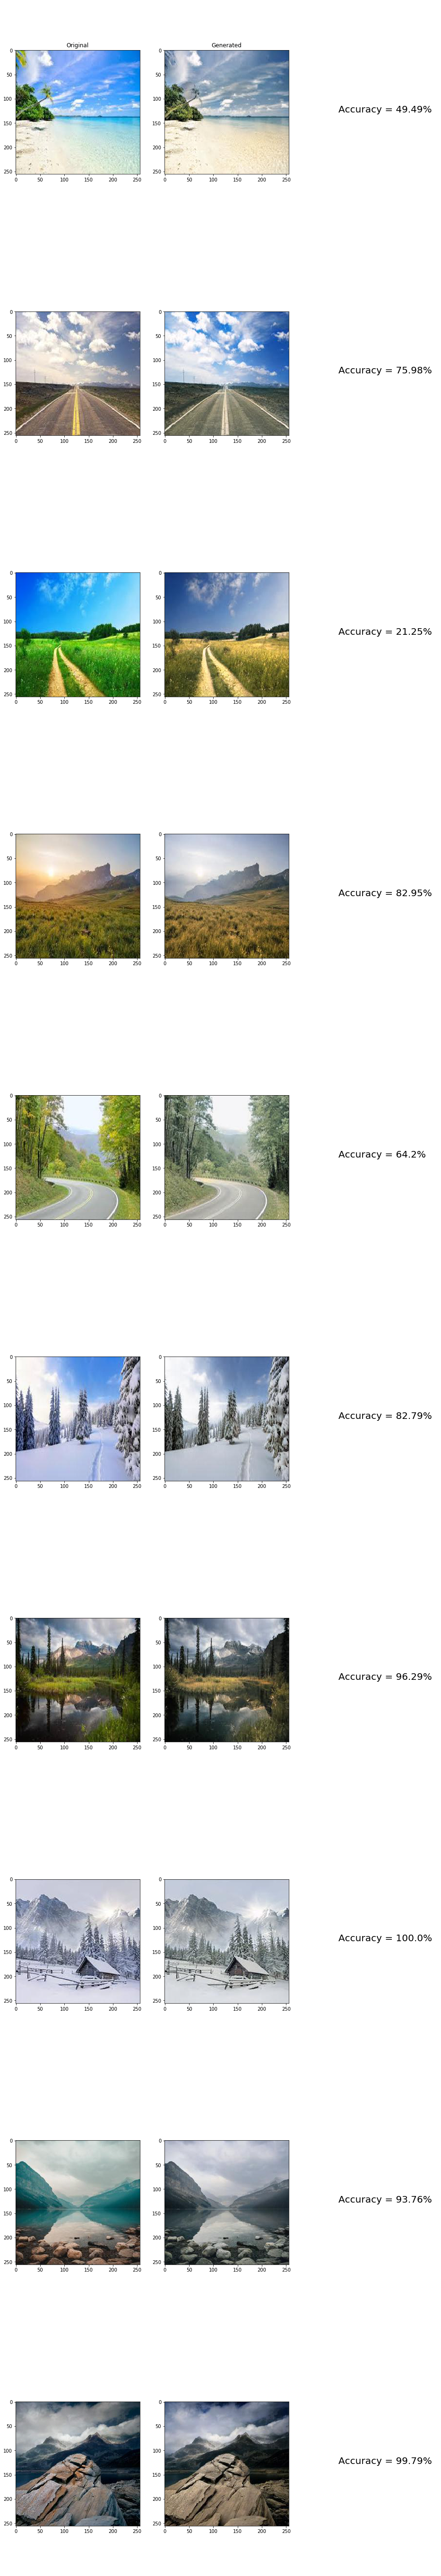

In [7]:
fig, ax = plt.subplots(10, 3, figsize=(16, 100))
row = 0

ax[0][0].set_title("Original")
ax[0][1].set_title("Generated")

for filename in images:
    ax[row, 0].imshow(load_img(PATH_TO_RESIZED_FOLDER + "\\" + filename), interpolation = 'nearest')
    row += 1

colorize = np.array(colorize, dtype = float)
original_images = colorize
colorize = rgb2lab(1.0 / 255 * colorize)[:, :, :, 0]
colorize = colorize.reshape(colorize.shape + (1, ))

# Test model
output = loaded_model.predict(colorize)

# Output colorizations
row = 0
for filename in images:
    resImage = load_img(PATH_TO_MODEL1_OUTPUT + '\\' + filename)
    origImage = load_img(PATH_TO_RESIZED_FOLDER + '\\' + filename)
    image_acc = calc_acc(np.asarray(origImage) / 256, np.asarray(resImage) / 256)
    ax[row, 1].imshow(resImage, interpolation = 'nearest')
    ax[row, 2].text(0.2, 0.5, 'Accuracy = ' + str(round(image_acc * 100, 2)) + "%", fontdict=dict(size=20))
    ax[row, 2].axis("off")
    row += 1


## Model 2 Output

In [13]:
json_file = open(PATH_TO_MODEL_2_JSON, 'r')
loaded_model_json = json_file.read()
json_file.close()
model = model_from_json(loaded_model_json)
# load weights into new model
model.load_weights(PATH_TO_MODEL_2_WEIGHTS)

In [14]:
inception = InceptionResNetV2(weights = 'imagenet', include_top = True)

def create_inception_embedding(grayscaled_rgb):
    grayscaled_rgb_resized = []
    for i in grayscaled_rgb:
        i = resize(i, (299, 299, 3), mode = 'constant')
        grayscaled_rgb_resized.append(i)
    grayscaled_rgb_resized = np.array(grayscaled_rgb_resized)
    grayscaled_rgb_resized = preprocess_input(grayscaled_rgb_resized)
    embed = inception.predict(grayscaled_rgb_resized)
    return embed

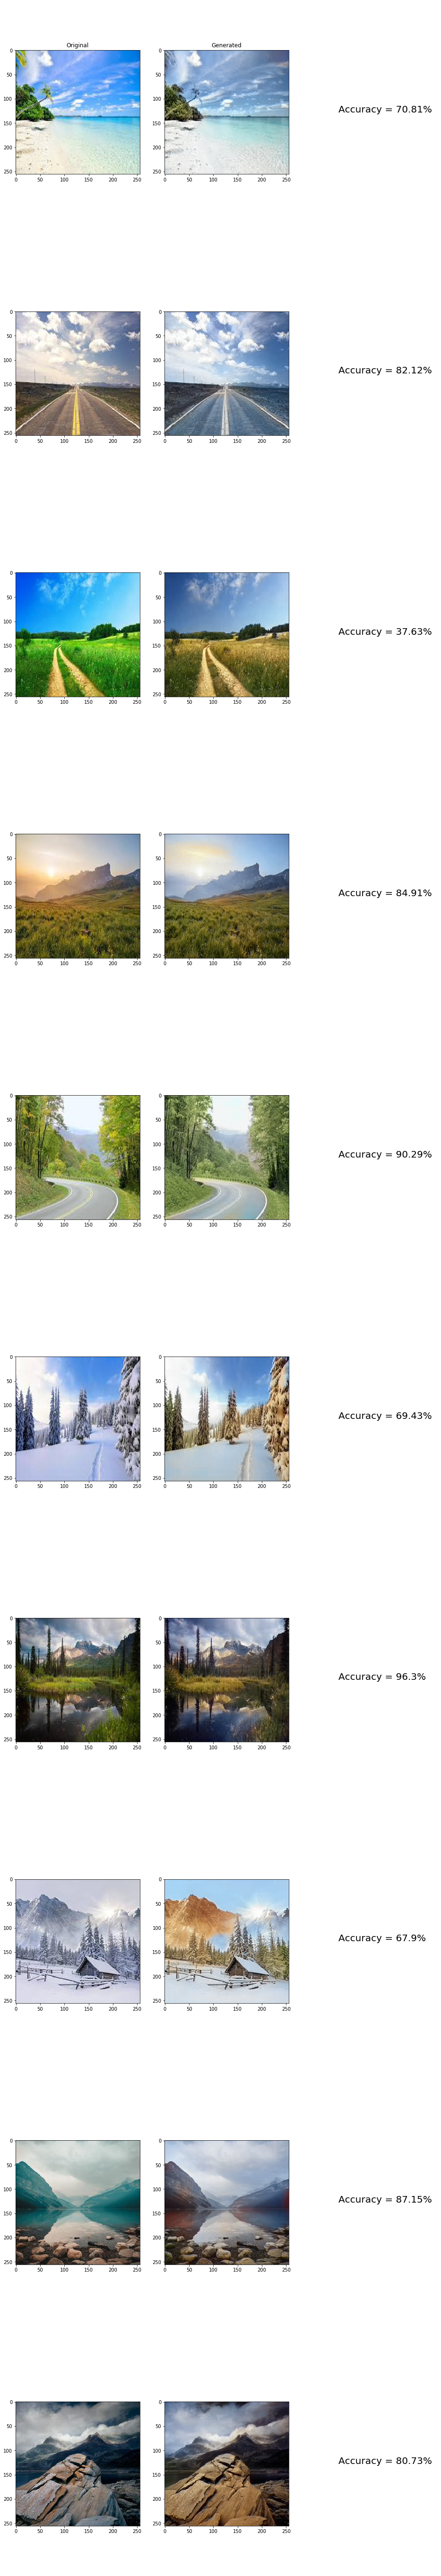

In [15]:
fig, ax = plt.subplots(10, 3, figsize = (16, 100))
row = 0
color_me = []

ax[0][0].set_title("Original")
ax[0][1].set_title("Generated")

for filename in images:
    color_me.append(img_to_array(load_img(PATH_TO_RESIZED_FOLDER + "\\" + filename)))
    ax[row, 0].imshow(load_img(PATH_TO_RESIZED_FOLDER + "\\" + filename), interpolation = 'nearest')
    row += 1

color_me = np.array(color_me, dtype = float)
# origial_images = color_me
gray_me = gray2rgb(rgb2gray(1.0 / 255 * color_me))
color_me_embed = create_inception_embedding(gray_me)
color_me = rgb2lab(1.0 / 255 * color_me)[:, :, :, 0]
color_me = color_me.reshape(color_me.shape + (1, ))

# Test model
output = model.predict([color_me, color_me_embed])

row = 0
for filename in images:
    resImage = load_img(PATH_TO_MODEL2_OUTPUT + '\\' + filename)
    origImage = load_img(PATH_TO_RESIZED_FOLDER + '\\' + filename)
    image_acc = calc_acc(np.asarray(origImage) / 256, np.asarray(resImage) / 256)
    ax[row, 1].imshow(resImage, interpolation = 'nearest')
    ax[row, 2].text(0.2, 0.5, 'Accuracy = ' + str(round(image_acc * 100, 2)) + "%", fontdict=dict(size=20))
    ax[row, 2].axis("off")
    row += 1